# Test 1D: constant velocity gradient
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import scipy             as sp
import torch
plt.rcParams["font.family"] = "serif"

from astropy         import units, constants
from scipy.integrate import quad
from p3droslo.lines  import Line
from p3droslo.loss   import Loss
from p3droslo.model  import TensorModel, SphericalModel
from p3droslo.utils  import planck

In [2]:
# Line data
lines = [Line('CO', i) for i in range(1)]

# Frequency data
vdiff = 500   # velocity increment size [m/s]
nfreq = 100   # number of frequencies

velocities  = nfreq * vdiff * torch.linspace(-1, +1, nfreq, dtype=torch.float64)
frequencies = [(1.0 + velocities / constants.c.si.value) * line.frequency for line in lines]

You have selected line:
    CO(J=1-0)
Please check the properties that were inferred:
    Frequency         1.152712018e+11  Hz
    Einstein A coeff  7.203000000e-08  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [46]:
n_elements = 1024

r_in  = (1.0e+0 * units.au).si.value
r_out = (1.0e+2 * units.au).si.value

# rs = np.logspace(np.log10(r_in), np.log10(r_out), n_elements)
rs = np.linspace(         r_in ,          r_out , n_elements)

T     = (1.0e+2 * units.K).si.value
T_bdy = (2.7e+2 * units.K).si.value

nCO_in = 1.0e+12

vmax = (1.5e+1 * units.km / units.s).si.value

n_CO = nCO_in * np.ones(n_elements)

v_turb = (1.5 * units.km / units.s).si.value

I_bdy = planck(temperature=T_bdy, frequency=frequencies[0])

model = TensorModel(sizes=r_out, shape=n_elements)
# Define and initialise the model variables
model['log_CO'        ] = np.log(n_CO)
model['log_velocity'  ] = np.log(vmax/r_out * rs)
model['log_turbulence'] = np.log(v_turb) * np.ones(n_elements)
model['log_T'         ] = np.log(T)
model['log_T_bdy'     ] = np.log(T_bdy)

In [47]:
def get_velocity(model):
    return torch.exp(model['log_velocity'])
    # return 1000 * torch.ones_like(model['log_CO'])

def get_temperature(model):
    return torch.exp(model['log_T']) * torch.ones_like(model['log_CO'])

def get_abundance(model):
    return torch.exp(model['log_CO'])

def get_turbulence(model):
    return torch.exp(model['log_turbulence'])

def get_boundary_condition(model, frequency, b):
    T_bdy = torch.exp(model['log_T_bdy'])
    return torch.zeros_like(frequency)
    # return planck(temperature=T_bdy, frequency=frequency)
        
smodel = SphericalModel(rs, model, r_star=0.0)
smodel.get_velocity           = get_velocity
smodel.get_abundance          = get_abundance
smodel.get_turbulence         = get_turbulence
smodel.get_temperature        = get_temperature
smodel.get_boundary_condition = get_boundary_condition

In [48]:
eta_ij, chi_ij = lines[0].emissivity_and_opacity_ij(lines[0].LTE_pops(torch.Tensor([T])))
dnu            = lines[0].gaussian_width(torch.exp(model['log_T']), torch.exp(model['log_turbulence'])).mean().item()

S = (eta_ij / chi_ij).item()

def tau(b, nu):
    l = 2.0 * np.sqrt(r_out**2 + b**2)
    L = r_out
    frq = lines[0].frequency
    arg = (nu - frq) / dnu
    fct = (vmax / constants.c.si.value) * (nu / dnu)
    return chi_ij.item() * nCO_in * L / (fct*dnu) * 0.5 * (sp.special.erf(fct*l/L+arg) - sp.special.erf(arg))

def I(b, nu):
    Ib = 0.0
    # Ib = planck(temperature=T_bdy, frequency=nu)
    return S + (Ib - S) * np.exp(-tau(b, nu))

def integrant(b, nu):
    return 2.0 * np.pi * b * I(b, nu)

def I_int(nu):
    return quad(integrant, 0.0, r_out, args=nu)

Is_test = [I_int(nu)[0] for nu in frequencies[0].tolist()]

/tmp/ipykernel_3719941/2058519832.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrant, 0.0, r_out, args=nu)


In [49]:
Is = smodel.image(lines, frequencies)

100%|██████████| 1023/1023 [00:05<00:00, 193.50it/s]


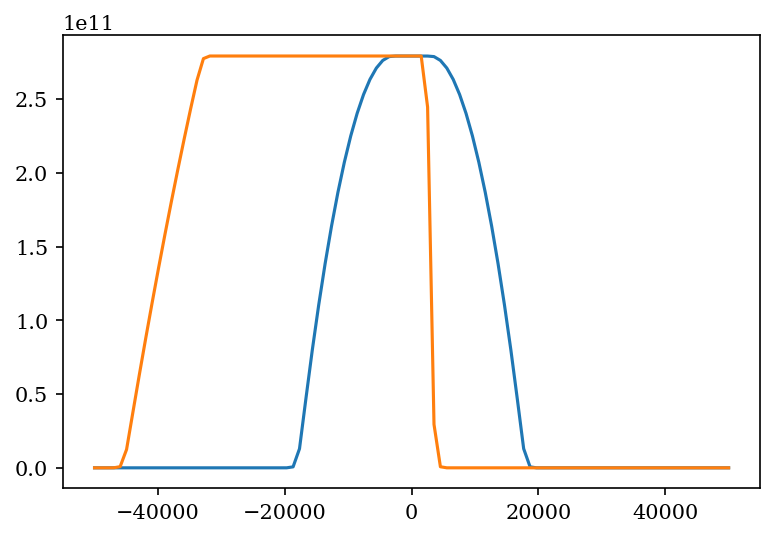

In [58]:
plt.figure(dpi=150)
plt.plot(velocities, Is[0].data)
plt.plot(velocities, Is_test)
# plt.plot(velocities, I_bdy)
# plt.yscale('log')

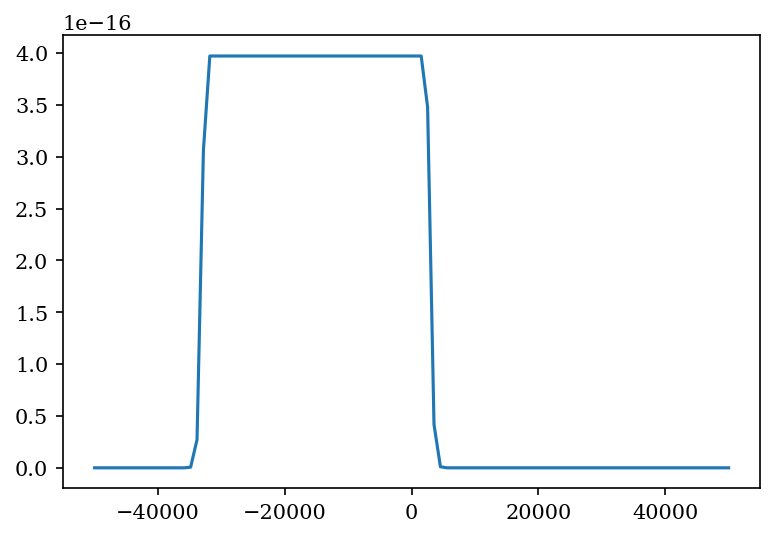

In [51]:
plt.figure(dpi=150)
plt.plot(velocities, I(rs[100], frequencies[0]))

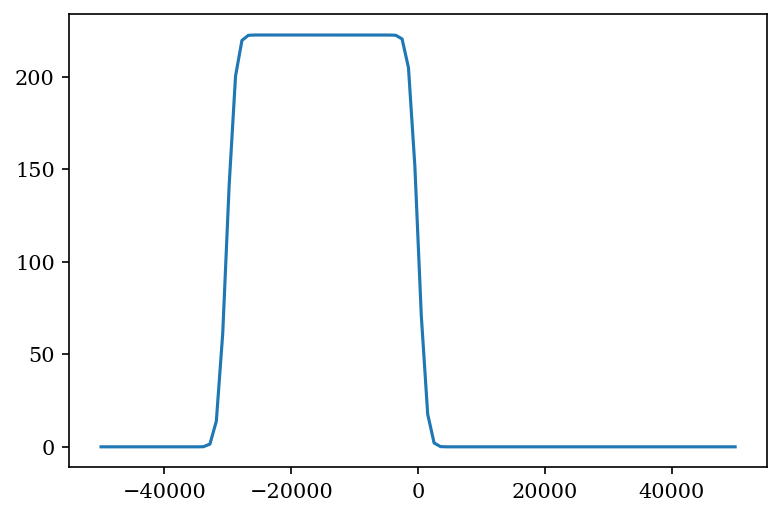

In [52]:
plt.figure(dpi=150)
plt.plot(velocities, tau(rs[100], frequencies[0]))

In [53]:
velocity    = smodel.get_velocity   (smodel.model_1D)
abundance   = smodel.get_abundance  (smodel.model_1D)
temperature = smodel.get_temperature(smodel.model_1D)
turbulence  = smodel.get_turbulence (smodel.model_1D)

line = lines[0]
freq = torch.Tensor([line.frequency])

I_cen = []
I_cen_test = []

for i in range(smodel.Nb):
    # Get boundary condition at this impact parameter
    img_bdy = smodel.get_boundary_condition(smodel.model_1D, frequency=freq, b=smodel.rs[i])

    velocity_los = velocity   [smodel.idss[i]] * smodel.diss[i]
    velocity_los = velocity_los - velocity_los.min()

    # Get intensity at this impact parameter
    I_loc = line.LTE_image_along_last_axis(
        abundance    = abundance  [smodel.idss[i]],
        temperature  = temperature[smodel.idss[i]],
        v_turbulence = turbulence [smodel.idss[i]],
        velocity_los = velocity_los,
        frequencies  = freq,
        dx           = smodel.dZss[i],
        img_bdy      = img_bdy
    )

    I_cen     .append(I_loc.item())
    I_cen_test.append(I(rs[i], freq))

/home/frederikd/.conda/envs/magritte/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/frederikd/.conda/envs/magritte/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


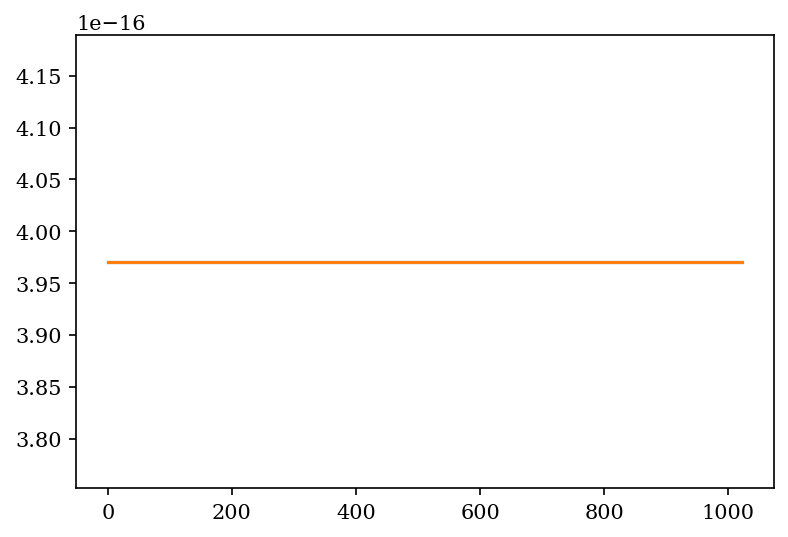

In [54]:
plt.figure(dpi=150)
plt.plot(I_cen)
plt.plot(I_cen_test)

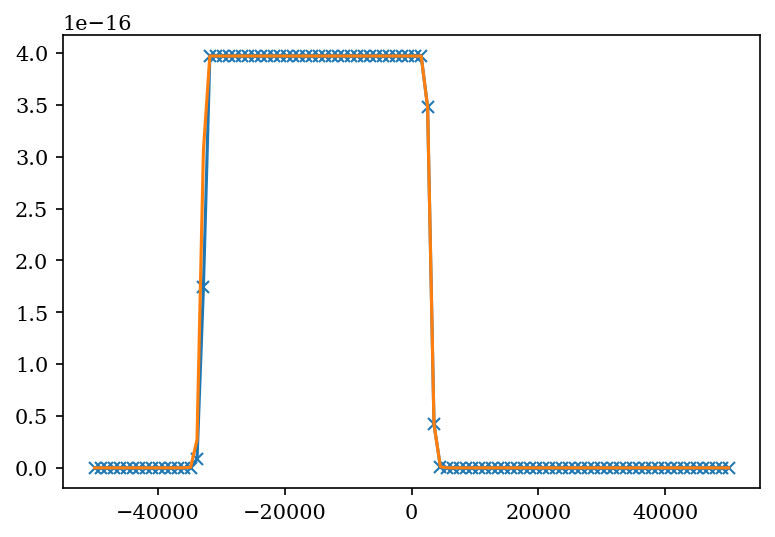

In [55]:
i = 100
    
# Get boundary condition at this impact parameter
img_bdy = smodel.get_boundary_condition(smodel.model_1D, frequency=freq, b=smodel.rs[i])

velocity_los = velocity   [smodel.idss[i]] * smodel.diss[i]
velocity_los = velocity_los - velocity_los.min()

# Get intensity at this impact parameter
I_loc = line.LTE_image_along_last_axis(
    abundance    = abundance  [smodel.idss[i]],
    temperature  = temperature[smodel.idss[i]],
    v_turbulence = turbulence [smodel.idss[i]],
    velocity_los = velocity_los,
    frequencies  = frequencies[0],
    dx           = smodel.dZss[i],
    img_bdy      = img_bdy
)

I_test = I(rs[i], frequencies[0])

plt.figure(dpi=150)
plt.plot(velocities, I_loc, marker='x')
plt.plot(velocities, I_test)

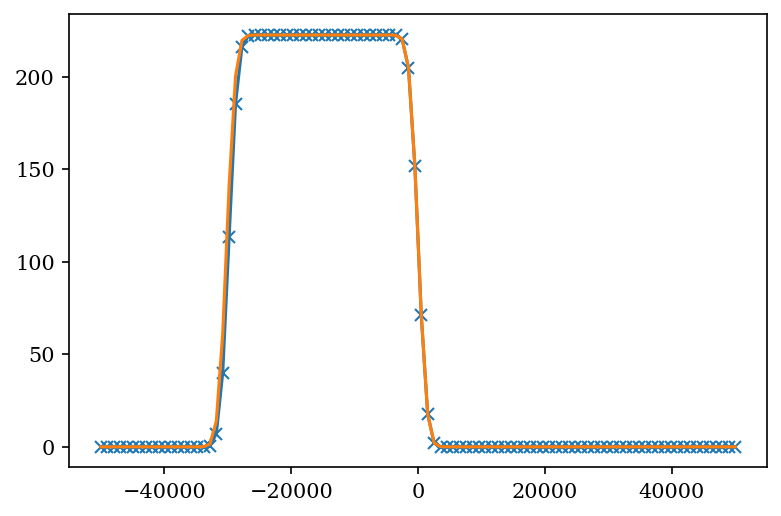

In [56]:
pop = line.LTE_pops(temperature = temperature[smodel.idss[i]])

eta_ij_loc, chi_ij_loc = line.emissivity_and_opacity_ij(pop=pop)

velocity_los = velocity   [smodel.idss[i]] * smodel.diss[i]
velocity_los = velocity_los - velocity_los.min()

dtau_, tau_ = line.optical_depth_along_last_axis(
            chi_ij       = chi_ij_loc,
            abundance    = abundance  [smodel.idss[i]],
            temperature  = temperature[smodel.idss[i]],
            v_turbulence = turbulence [smodel.idss[i]],
            velocity_los = velocity_los,
            frequencies  = frequencies[0],
            dx           = smodel.dZss[i]
        )

tau_test = tau(rs[i], frequencies[0])

plt.figure(dpi=150)
plt.plot(velocities, tau_[-1], marker='x')
plt.plot(velocities, tau_test)
# plt.yscale('log')

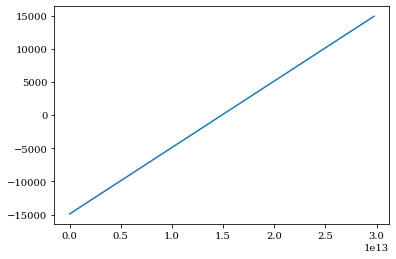

In [57]:
plt.plot(np.cumsum(smodel.dZss[i]), (velocity   [smodel.idss[i]] * smodel.diss[i])[1:])

In [41]:
np.cumsum(smodel.dZss[i]).shape

(2026,)

In [42]:
(velocity   [smodel.idss[i]] * smodel.diss[i]).shape

torch.Size([2027])

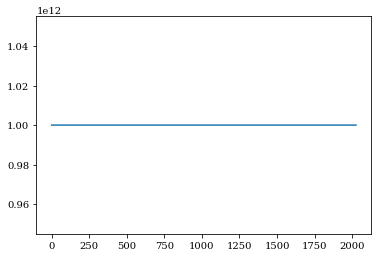

In [43]:
plt.plot(abundance  [smodel.idss[i]])